In [1]:
!pip install sentence_transformers umap_learn datasets seaborn

# Few shot learning using a basic embedding model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.GDA import GDA

In [3]:
from datasets import load_dataset

ds = load_dataset("Yelp/yelp_review_full")

d:\libs\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_train, y_test = train_test_split(ds["train"]["text"], ds["train"]["label"], train_size=500, random_state=42)

In [5]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim


llm_model = SentenceTransformer("sentence-transformers/all-distilroberta-v1")
N = 2000

X_tr = llm_model.encode(X_tr)
y_train = np.array(y_train)
X_tr = X_tr
y_train = y_train
y_test = np.array(y_test)[:N]
X_test = llm_model.encode(X_te[:N])
y_test = y_test

## Visualize embedding

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X_test)

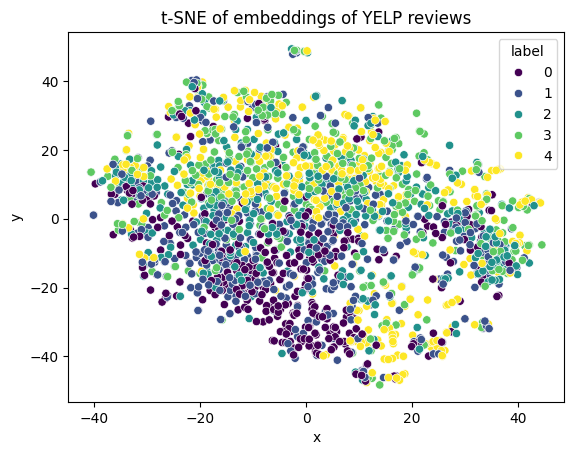

In [7]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X_tsne, columns=['x', 'y'])
df['label'] = y_test

# Create the scatter plot

sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis')
plt.title('t-SNE of embeddings of YELP reviews')
plt.savefig("scatterplot.png")
plt.show()


In [8]:
m = 80
X_tr = X_tr
X_train = X_tr[:m]

In [9]:
# gmda = GDA(n_components=3, model_name="student", degrees_of_freedom=4)
gmda = GDA(n_components=3, model_name="bic", covariance_type="tied")

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(np.concatenate([X_train]))

X_train_pca = pca.transform(X_train)


In [11]:
gmda.fit(X_train_pca, y_train[:m])

In [12]:
X_test_r = X_test
X_test_r = pca.transform(X_test_r)
y_pred_gmda = gmda.predict(X_test_r)

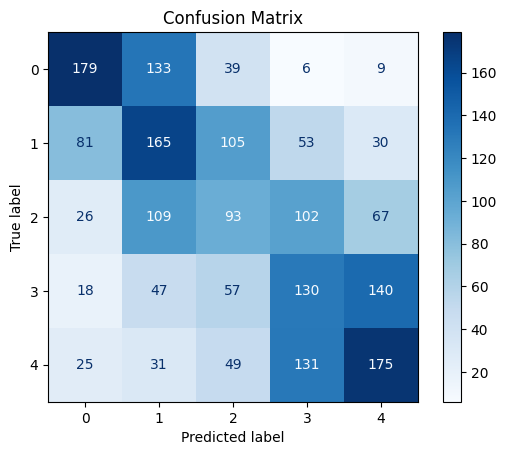

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_gmda)

# Display confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("cm.png")
plt.show()


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_gmda))

              precision    recall  f1-score   support

           0       0.54      0.49      0.52       366
           1       0.34      0.38      0.36       434
           2       0.27      0.23      0.25       397
           3       0.31      0.33      0.32       392
           4       0.42      0.43      0.42       411

    accuracy                           0.37      2000
   macro avg       0.38      0.37      0.37      2000
weighted avg       0.37      0.37      0.37      2000



In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Build benchmark feedforward neural network
class BasicMLP(nn.Module):
    def __init__(self):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 5),
        )
    def forward(self, x):
        return self.ffnn(x)

In [16]:
import torch.optim as optim

model = BasicMLP()
optimizer = optim.Adam(model.parameters(),)
loss_fn = nn.CrossEntropyLoss()

In [17]:
from torch.utils.data import TensorDataset, DataLoader
import torch

x_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train[:m], dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [18]:
EPOCHS = 40 # Avoid overfitting on the train set

for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        print(running_loss)

EPOCH 1:
1.6310373544692993
EPOCH 6:
1.6033878326416016
EPOCH 11:
1.5707942247390747
EPOCH 16:
1.5243897438049316
EPOCH 21:
1.4612488746643066
EPOCH 26:
1.3814918994903564
EPOCH 31:
1.2885773181915283
EPOCH 36:
1.1861071586608887


In [19]:
x_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)
dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=N, shuffle=True)

In [20]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

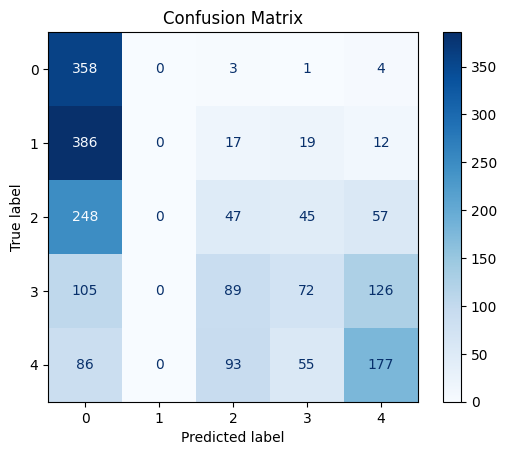

In [21]:
true_labels = []
predicted_labels = []

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()


In [22]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.30      0.98      0.46       366
           1       0.00      0.00      0.00       434
           2       0.19      0.12      0.15       397
           3       0.38      0.18      0.25       392
           4       0.47      0.43      0.45       411

    accuracy                           0.33      2000
   macro avg       0.27      0.34      0.26      2000
weighted avg       0.26      0.33      0.25      2000



d:\libs\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\libs\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\libs\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
def weighted_accuracy(cm):
    weighted_accuracy = 0
    for i in range(len(cm)):
        for j in range(len(cm)):
            weighted_accuracy += np.abs(i - j) / 5 * cm[i, j]
    return  weighted_accuracy/ (np.sum(np.sum(cm)))

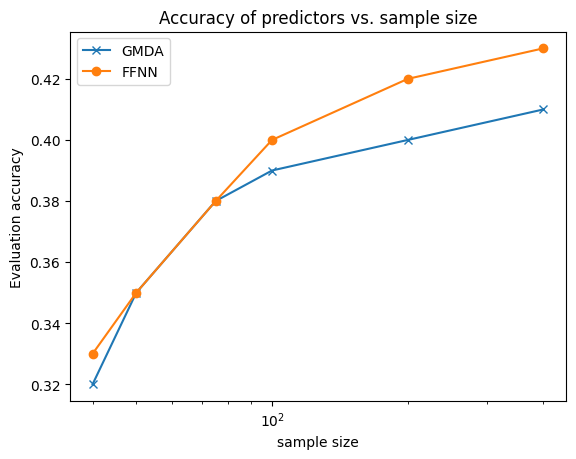

In [31]:
plot_x = [40, 50, 75, 100, 200, 400]
plot_gmm = [0.32, 0.35, 0.38, 0.39, 0.4, 0.41]
plot_dl = [0.33, 0.35, 0.38, 0.4, 0.42, 0.43]

plt.plot(plot_x, plot_gmm, marker="x", label="GMDA")
plt.plot(plot_x, plot_dl, marker="o", label="FFNN")
plt.xscale("log")
plt.xlabel("sample size")
plt.ylabel("Evaluation accuracy")
plt.title("Accuracy of predictors vs. sample size")
plt.legend()